In [1]:
# utility
import sys
sys.path.append("..")

import utility

# data processing
import pandas as pd
import numpy as np

# modelling keras
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, BinaryCrossentropy

# visualization
import matplotlib.pyplot as plt

In [2]:
start_time = utility.time.time()

stop_thread = False

# global parameters
max_cpu_usage = 0
max_memory_usage = 0

def collect_cpu_mem_usage():
    global max_cpu_usage, max_memory_usage

    while not stop_thread:
        # Get current CPU and memory usage
        cpu_usage = utility.psutil.cpu_percent()
        memory_usage = utility.psutil.virtual_memory().percent

        # Initialize variables if not yet assigned
        if max_cpu_usage is None:
            max_cpu_usage = cpu_usage
        if max_memory_usage is None:
            max_memory_usage = memory_usage

        # Update maximum values if needed
        max_cpu_usage = max(max_cpu_usage, cpu_usage)
        max_memory_usage = max(max_memory_usage, memory_usage)

        # Sleep for a short interval (adjust as needed)
        utility.time.sleep(1)

# Start the function in a separate thread
thread = utility.threading.Thread(target=collect_cpu_mem_usage)
thread.start()

In [3]:
data, labels, _ = utility.load_data()

Dataset split: 70000 train rows
Dataset split: 70000 test rows


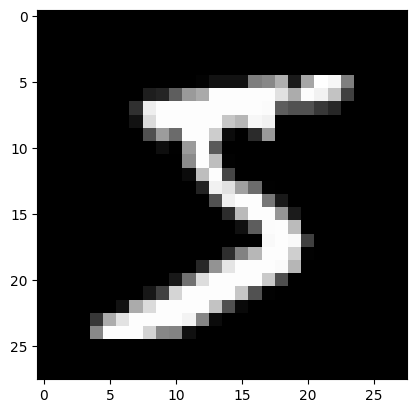

In [4]:
print(f"Dataset split: {len(data)} train rows")
print(f"Dataset split: {len(labels)} test rows")

point = data[0].reshape(28, 28)

plt.imshow(point, cmap='gray')
plt.show()

In [5]:
train_data, train_labels, test_data, test_labels, val_data, val_labels, test_true_labels, anom_data = utility.preprocess_data(data, labels)

In [6]:
# Best Hyperparameters:
# {'optimizer': 'adam', 'activation': 'sigmoid', 'loss': <keras.src.losses.MeanSquaredError object at 0x7f3783d3b9a0>, 'regularizer': None, 'dropout_rate': 0.0, 'epochs': 150, 'batch_size': 256}
# Best Validation Loss: 0.0071600452065467834

# Best Hyperparameters:
# {'optimizer': 'rmsprop', 'activation': 'sigmoid', 'loss': <keras.src.losses.MeanSquaredError object at 0x7f2c98c1f9d0>, 'regularizer': None, 'dropout_rate': 0.0, 'epochs': 150, 'batch_size': 64}
# Best Validation Loss: 0.008536080829799175

In [7]:
# parameters
optimizer = 'adam'
activation = 'sigmoid'
loss = MeanSquaredError()
regularizer = None
dropout_rate = 0.0
epochs = 150
batch_size = 256

In [8]:
# Input image
input_img = Input(shape=(784,))

In [9]:
# encoder
encoded = Dense(256, activation='relu', kernel_regularizer=regularizer)(input_img)
encoded = BatchNormalization()(encoded)
encoded = Dense(128, activation='relu', kernel_regularizer=regularizer)(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dropout(rate=dropout_rate)(encoded)
encoded = Dense(32, activation='relu')(encoded)

In [10]:
# decoder
decoded = Dense(32, activation='relu', kernel_regularizer=regularizer)(encoded)
decoded = BatchNormalization()(decoded)
decoded = Dense(64, activation='relu', kernel_regularizer=regularizer)(decoded)
decoded = Dropout(rate=dropout_rate)(decoded)
decoded = Dense(128, activation='relu', kernel_regularizer=regularizer)(decoded)
decoded = Dense(256, activation='relu', kernel_regularizer=regularizer)(decoded)
decoded = Dense(784, activation=activation)(decoded)

In [11]:
autoencoder = Model(input_img, decoded)

In [12]:
autoencoder.compile(optimizer=optimizer, loss=loss)

In [13]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = autoencoder.fit(train_data, train_data, epochs=epochs, batch_size=batch_size, shuffle=True,
                          validation_data=(val_data, val_data), callbacks=[early_stopping])

Epoch 1/150
175/175 [==============================] - 7s 16ms/step - loss: 0.0591 - val_loss: 0.0419
Epoch 2/150
175/175 [==============================] - 2s 14ms/step - loss: 0.0308 - val_loss: 0.0310
Epoch 3/150
175/175 [==============================] - 2s 14ms/step - loss: 0.0247 - val_loss: 0.0259
Epoch 4/150
175/175 [==============================] - 2s 14ms/step - loss: 0.0213 - val_loss: 0.0218
Epoch 5/150
175/175 [==============================] - 2s 14ms/step - loss: 0.0192 - val_loss: 0.0194
Epoch 6/150
175/175 [==============================] - 2s 13ms/step - loss: 0.0178 - val_loss: 0.0175
Epoch 7/150
175/175 [==============================] - 2s 13ms/step - loss: 0.0166 - val_loss: 0.0160
Epoch 8/150
175/175 [==============================] - 2s 13ms/step - loss: 0.0157 - val_loss: 0.0160
Epoch 9/150
175/175 [==============================] - 2s 13ms/step - loss: 0.0149 - val_loss: 0.0153
Epoch 10/150
175/175 [==============================] - 2s 13ms/step - loss: 0.014

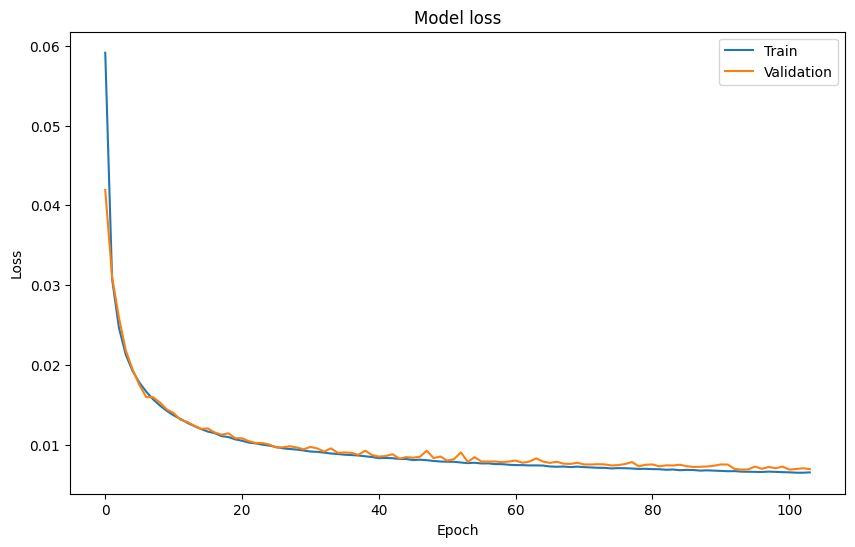

In [14]:
# Plot training history
plt.figure(figsize=(10, 6))

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

313/313 [==============================] - 1s 2ms/step


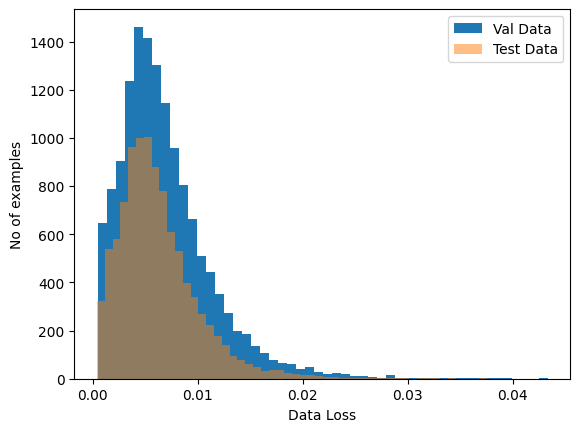

In [15]:
reconstructions = autoencoder.predict(val_data)
val_loss = tf.keras.losses.mse(reconstructions, val_data)

reconstructions_test = autoencoder.predict(test_data)
test_loss = tf.keras.losses.mse(reconstructions_test, test_data)

plt.hist(val_loss[None,:], bins=50, label='Val Data')
plt.hist(test_loss[None,:], bins=50, alpha=0.5, label='Test Data')
plt.xlabel("Data Loss")
plt.ylabel("No of examples")
plt.legend()
plt.show()

In [16]:
threshold = np.mean(val_loss) + np.std(val_loss)
print("Threshold ", threshold)

# Choose a quantile (e.g., 99th percentile) for the threshold
# threshold = np.percentile(train_loss, 99)
# print("Quantile Threshold ", threshold)

Threshold  0.011299973


In [17]:
threshold_anom = np.mean(test_loss) + np.std(test_loss)
print("Threshold ", threshold_anom)

Threshold  0.009994611


In [18]:
pred = autoencoder.predict(test_data)

313/313 [==============================] - 1s 2ms/step


In [19]:
preds, loss, proba = utility.predict(autoencoder, test_data, threshold)

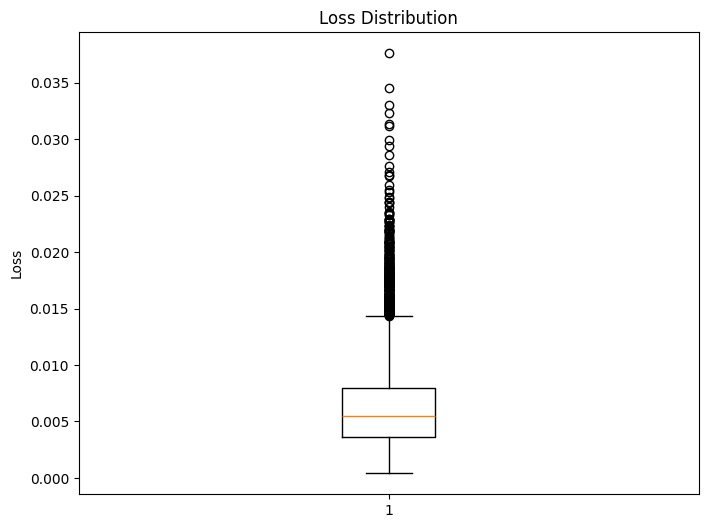

In [20]:
q1, q3, iqr, minimum, maximum = utility.boxplot_plot("Loss", loss)

In [21]:
utility.print_boxplot(q1, q3, iqr, minimum, maximum)

Q1:  0.004
Q3:  0.008
IQR:  0.004
Minimum:  0.0
Maximum:  0.014


C:\Users\zippe\AppData\Local\Temp\ipykernel_20528\1046356683.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(range(len(loss)), loss, c=['red' if e > threshold else 'blue' for e in loss], cmap='coolwarm', marker='o', edgecolors='k')


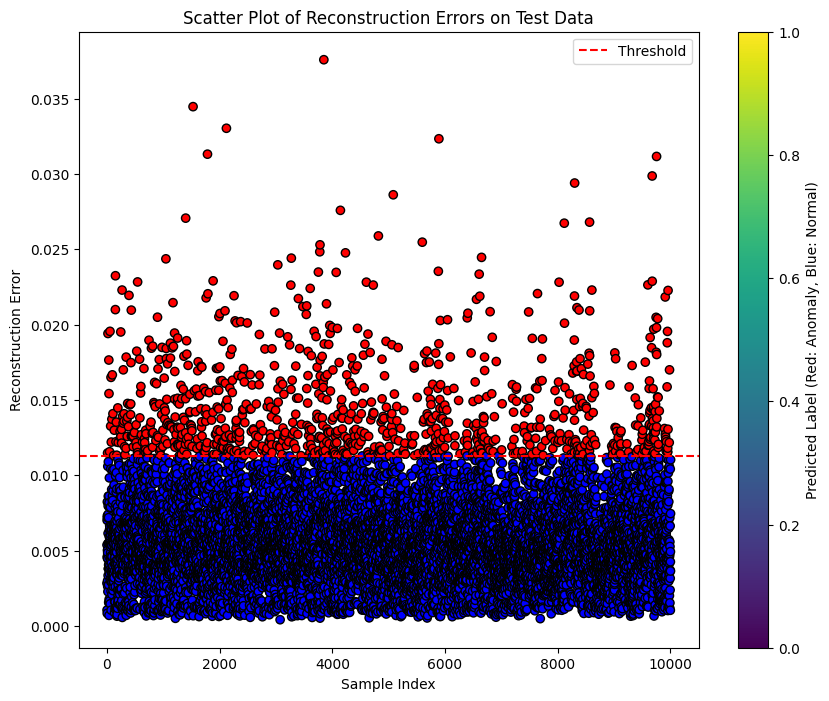

In [22]:
# Create a binary array indicating anomalies
anomaly_indicator = np.where(loss > threshold, 1, 0)

# Scatter plot with anomalies and normal instances based on anomaly prediction and threshold
plt.figure(figsize=(10, 8))
scatter = plt.scatter(range(len(loss)), loss, c=['red' if e > threshold else 'blue' for e in loss], cmap='coolwarm', marker='o', edgecolors='k')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.title('Scatter Plot of Reconstruction Errors on Test Data')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.colorbar(scatter, label='Predicted Label (Red: Anomaly, Blue: Normal)')
plt.show()

In [23]:
a, p, r, f1, report, cm = utility.get_metrics(preds, test_true_labels)

In [24]:
utility.print_stats(a, p, r, f1, report, cm)

Accuracy = 0.9081367453018793
Precision = 1.0
Recall = 0.9081
F1 = 0.951836905822546
Report
               precision    recall  f1-score   support

     anomaly       0.00      1.00      0.01         4
      normal       1.00      0.91      0.95     10000

    accuracy                           0.91     10004
   macro avg       0.50      0.95      0.48     10004
weighted avg       1.00      0.91      0.95     10004

Confusion Matrix
[[   4    0]
 [ 919 9081]]


True Negatives: 4
False Positives: 0
False Negatives: 919
True Positives: 9081


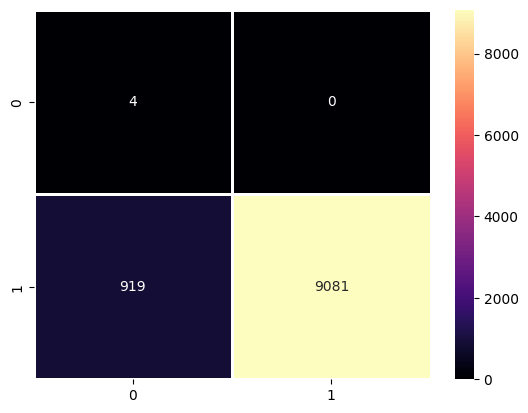

In [25]:
utility.create_heatmap(cm)

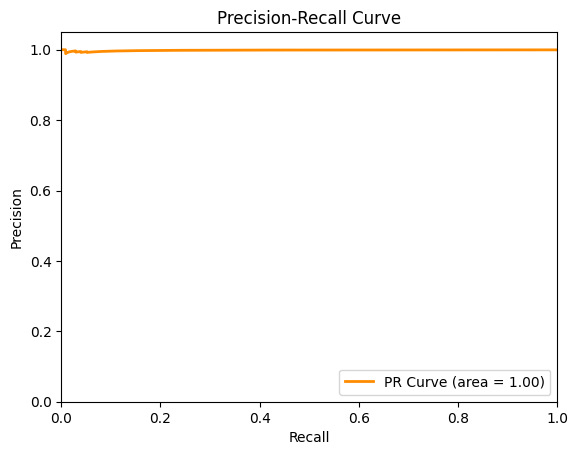

In [26]:
utility.pr_auc_plot(proba, test_true_labels)

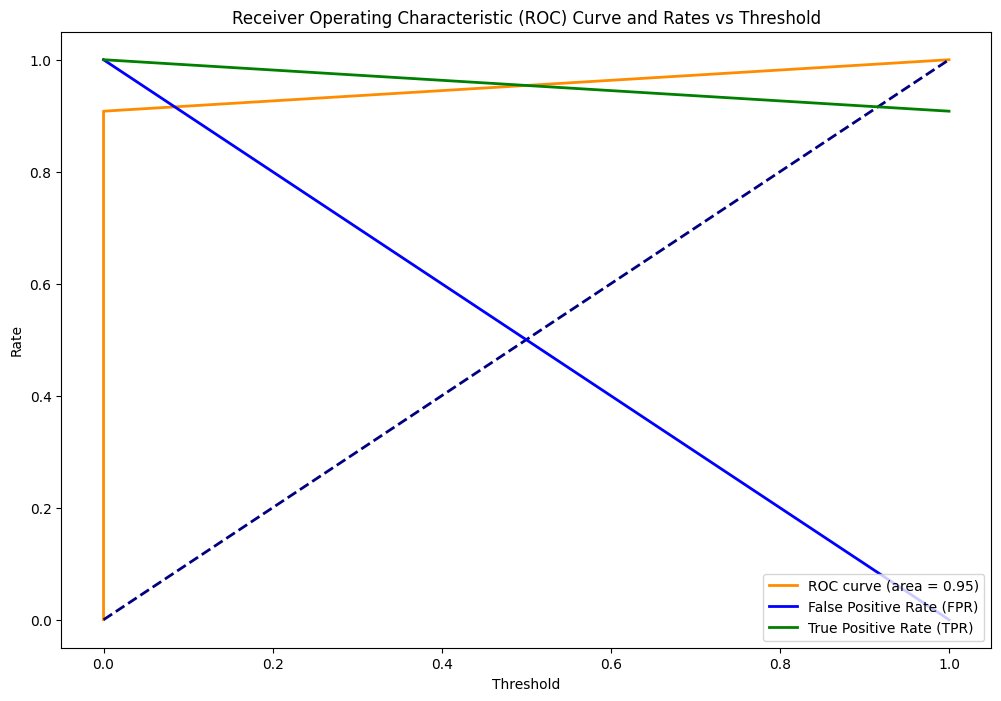

In [27]:
utility.roc_plot(preds, test_true_labels)

In [28]:
reconstructions = autoencoder.predict(train_data)
train_loss = tf.keras.losses.mse(reconstructions, train_data)

reconstructions_test = autoencoder.predict(test_data)
test_loss = tf.keras.losses.mse(reconstructions_test, test_data)

reconstructions_anom = autoencoder.predict(anom_data)
anom_loss = tf.keras.losses.mse(reconstructions_anom, anom_data)

1/1 [==============================] - 0s 34ms/step


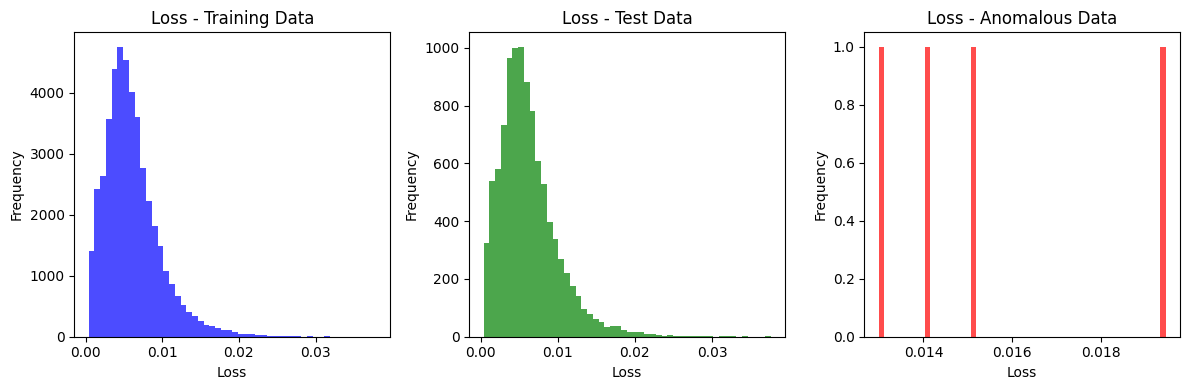

In [29]:
# Plotting histograms
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(train_loss[None,:], bins=50, color='blue', alpha=0.7)
plt.title('Loss - Training Data')
plt.xlabel('Loss')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(test_loss[None,:], bins=50, color='green', alpha=0.7)
plt.title('Loss - Test Data')
plt.xlabel('Loss')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(anom_loss[None,:], bins=50, color='red', alpha=0.7)
plt.title('Loss - Anomalous Data')
plt.xlabel('Loss')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [30]:
anomaly_indexes = utility.write_to_json(preds)

Anomaly indexes saved to .\anomalies.json


923


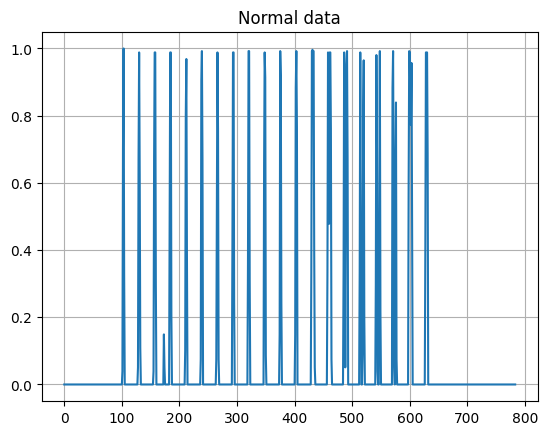

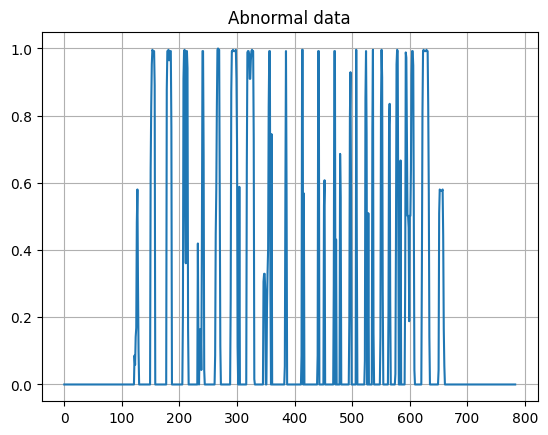

In [31]:
print(len(anomaly_indexes))

utility.plot_normalized_pixel_data(train_data, anom_data)

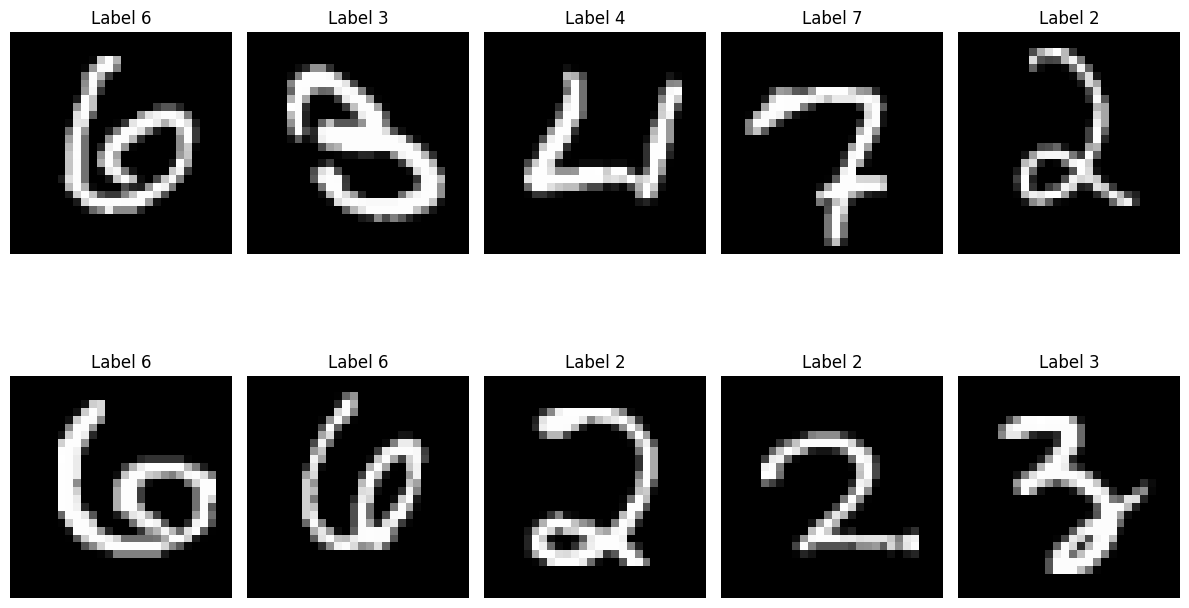

In [32]:
utility.plot_anomaly_imgs(anomaly_indexes, test_data, test_labels)

In [33]:
stop_thread = True

thread.join()
print(f"CPU Usage: {max_cpu_usage}%")
print(f"Memory Usage: {max_memory_usage}%")

CPU Usage: 100.0%
Memory Usage: 49.4%


In [34]:
end_time = utility.time.time()
total_time = end_time - start_time
print(f"Total execution time: {total_time} seconds")

Total execution time: 256.78462648391724 seconds
